In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
%load_ext autoreload
#%load_ext line_profiler
#%load_ext snakeviz
%autoreload 2

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import corner

import pickle

import enterprise
from enterprise.pulsar import Pulsar
import enterprise.signals.parameter as parameter
from enterprise.signals import utils
from enterprise.signals import signal_base
from enterprise.signals import selections
from enterprise.signals.selections import Selection
from enterprise.signals import white_signals
from enterprise.signals import gp_signals
from enterprise.signals import deterministic_signals
import enterprise.constants as const

from enterprise_extensions import deterministic

from scipy.stats import norm

import libstempo as T2
import libstempo.toasim as LT
import libstempo.plot as LP

import glob
import json
import h5py
import healpy as hp
import scipy.constants as sc
import emcee

from numba.typed import List

import sys
import h5py

In [2]:
#load psr pickles

#make sure this points to the same pickled pulsars we used for the MCMC
data_pkl = '/scratch/na00078/15yr_data/15yrCW/v1p1_de440_pint_bipm2019_unshifted_pdist.pkl'

#with open('nanograv_11yr_psrs_old.pkl', 'rb') as psr_pkl:
with open(data_pkl, 'rb') as psr_pkl:
    psrs = pickle.load(psr_pkl)
    
print(len(psrs))

67


In [3]:
#load psr names only if we want to save RAM
class psr_name:
    def __init__(self, name):
        self.name = name

psrListFile = "/scratch/na00078/15yr_data/15yr_v1_1/psrlist_15yr_pint.txt"

psrs = []
with open(psrListFile, 'r') as fff:
    for line in fff:
        psrname = line.strip()
        #print(psrname)
        psrs.append(psr_name(psrname))
        
print(len(psrs))
for i,psr in enumerate(psrs):
    print(str(i) + ": " + psr.name)

67
0: B1855+09
1: B1937+21
2: B1953+29
3: J0023+0923
4: J0030+0451
5: J0340+4130
6: J0406+3039
7: J0437-4715
8: J0509+0856
9: J0557+1551
10: J0605+3757
11: J0610-2100
12: J0613-0200
13: J0636+5128
14: J0645+5158
15: J0709+0458
16: J0740+6620
17: J0931-1902
18: J1012+5307
19: J1012-4235
20: J1022+1001
21: J1024-0719
22: J1125+7819
23: J1312+0051
24: J1453+1902
25: J1455-3330
26: J1600-3053
27: J1614-2230
28: J1630+3734
29: J1640+2224
30: J1643-1224
31: J1705-1903
32: J1713+0747
33: J1719-1438
34: J1730-2304
35: J1738+0333
36: J1741+1351
37: J1744-1134
38: J1745+1017
39: J1747-4036
40: J1751-2857
41: J1802-2124
42: J1811-2405
43: J1832-0836
44: J1843-1113
45: J1853+1303
46: J1903+0327
47: J1909-3744
48: J1910+1256
49: J1911+1347
50: J1918-0642
51: J1923+2515
52: J1944+0907
53: J1946+3417
54: J2010-1323
55: J2017+0603
56: J2033+1734
57: J2043+1711
58: J2124-3358
59: J2145-0750
60: J2214+3000
61: J2229+2643
62: J2234+0611
63: J2234+0944
64: J2302+4442
65: J2317+1439
66: J2322+2057


In [4]:
pwd

'/scratch/na00078/Jet_Source_Project/post_processing_scripts'

## Generate Outfile

In [6]:
#'''
#COMMENT IF OUTFILE GENERATED
#Thinning script for one source
i = "/scratch/na00078/Jet_Source_Project/results/1553+113.h5"

infile = i
first_n_param = 8
outfile = '/scratch/na00078/Jet_Source_Project/results/1553+113_outfile.h5'

print(infile)
print(first_n_param)
print(outfile)

with h5py.File(infile, 'r') as f:
    Ts = f['T-ladder'][...]
    samples_cold = f['samples_cold'][:,:,:]
    print("Infile sample shape", samples_cold[-1].shape)
    log_likelihood = f['log_likelihood'][:1,:]
    print("Infile loglikelihood shape", log_likelihood.shape)
    par_names = [x.decode('UTF-8') for x in list(f['par_names'])]
    acc_fraction = f['acc_fraction'][...]
    fisher_diag = f['fisher_diag'][...]

with h5py.File(outfile, 'w') as f:
    f.create_dataset('samples_cold', data=samples_cold[:,:,:first_n_param], compression="gzip", chunks=True)
    f.create_dataset('log_likelihood', data=log_likelihood[:,:], compression="gzip", chunks=True)
    f.create_dataset('par_names', data=np.array(par_names, dtype='S'))
    f.create_dataset('acc_fraction', data=acc_fraction)
    f.create_dataset('fisher_diag', data=fisher_diag)
    f.create_dataset('T-ladder', data=Ts)
#'''
###################################################
'''
with h5py.File(i, 'r') as f:
    print(list(f.keys()))
    samples_cold = f['samples_cold'][0,::10,:]
    print(f['samples_cold'].dtype)
    #samples = f['samples_cold'][...]
    #log_likelihood = f['log_likelihood'][:,::10]
    print(f['log_likelihood'].dtype)
    log_likelihood = f['log_likelihood'][...]
    par_names = [x.decode('UTF-8') for x in list(f['par_names'])]
    acc_fraction = f['acc_fraction'][...]
    fisher_diag = f['fisher_diag'][...]

#print(acc_fraction)
#print(acc_fraction[:,:])
#print(samples.shape)
#samples_cold = np.copy(samples[0,:,::])
print(samples_cold.shape)
#print(par_names)
'''


/scratch/na00078/Jet_Source_Project/results/1553+113.h5
8
/scratch/na00078/Jet_Source_Project/results/1553+113_outfile.h5
Infile sample shape (10000000, 278)
Infile loglikelihood shape (1, 10000000)


"\nwith h5py.File(i, 'r') as f:\n    print(list(f.keys()))\n    samples_cold = f['samples_cold'][0,::10,:]\n    print(f['samples_cold'].dtype)\n    #samples = f['samples_cold'][...]\n    #log_likelihood = f['log_likelihood'][:,::10]\n    print(f['log_likelihood'].dtype)\n    log_likelihood = f['log_likelihood'][...]\n    par_names = [x.decode('UTF-8') for x in list(f['par_names'])]\n    acc_fraction = f['acc_fraction'][...]\n    fisher_diag = f['fisher_diag'][...]\n\n#print(acc_fraction)\n#print(acc_fraction[:,:])\n#print(samples.shape)\n#samples_cold = np.copy(samples[0,:,::])\nprint(samples_cold.shape)\n#print(par_names)\n"

## Run Outfile

In [34]:
#COMMENT IF OUTFILE GENERATED
#Thinning script for one source
i = "/scratch/na00078/Jet_Source_Project/results/1553+113.h5"

infile = i
first_n_param = 8
# outfile = '/scratch/na00078/QuickCW_targeted_runs/results/3C66B_outfile.h5'

print(infile)
print(first_n_param)

with h5py.File(infile, 'r') as f:
    Ts = f['T-ladder'][...]
    samples_cold = f['samples_cold'][:,:,:first_n_param]
    print(samples_cold[-1].shape)
    log_likelihood = f['log_likelihood'][:1,:]
    print(log_likelihood.shape)
    par_names = [x.decode('UTF-8') for x in list(f['par_names'])]
    acc_fraction = f['acc_fraction'][...]
    fisher_diag = f['fisher_diag'][...]

/scratch/na00078/Jet_Source_Project/results/1553+113.h5
8
(10000000, 8)
(1, 10000000)


## Corner Plots

In [35]:
target_d_L = 1937.1 

hamp [4.5068535e-15 4.5068535e-15 4.0362585e-15 ... 3.4779832e-16 7.1941796e-16
 1.5630009e-15]
freq [2.9810124e-08 2.9810124e-08 2.9810124e-08 ... 2.4530619e-08 2.4530619e-08
 2.4530619e-08]
mc [8.6710415e+09 8.6710415e+09 8.6710415e+09 ... 2.1166696e+08 2.1166696e+08
 2.1166696e+08]
Length of logdL 9000000
required values 8.09554 2.9810124e-08 8671042000.0 1.740649e-16
dL min 1917.7289999999998
dL max 1956.471
10**log10_d_L [4639.361    4639.361    5180.2725   ...  108.44354    52.426384
   24.130806]
min 10**log10_d_L 0.0031538208
max 10**log10_d_L 124606310.0
d_L_mask [   1587    2220    2221 ... 8999267 8999646 8999947]
notd_L_mask1 [     37      53     112 ... 8999997 8999998 8999999]
notd_L_mask2 [      0       1       2 ... 8999991 8999995 8999996]
merged_non_dL [     37      53     112 ... 8999991 8999995 8999996]
Sample shape (9000000, 9)
dL_mask length 15948
9


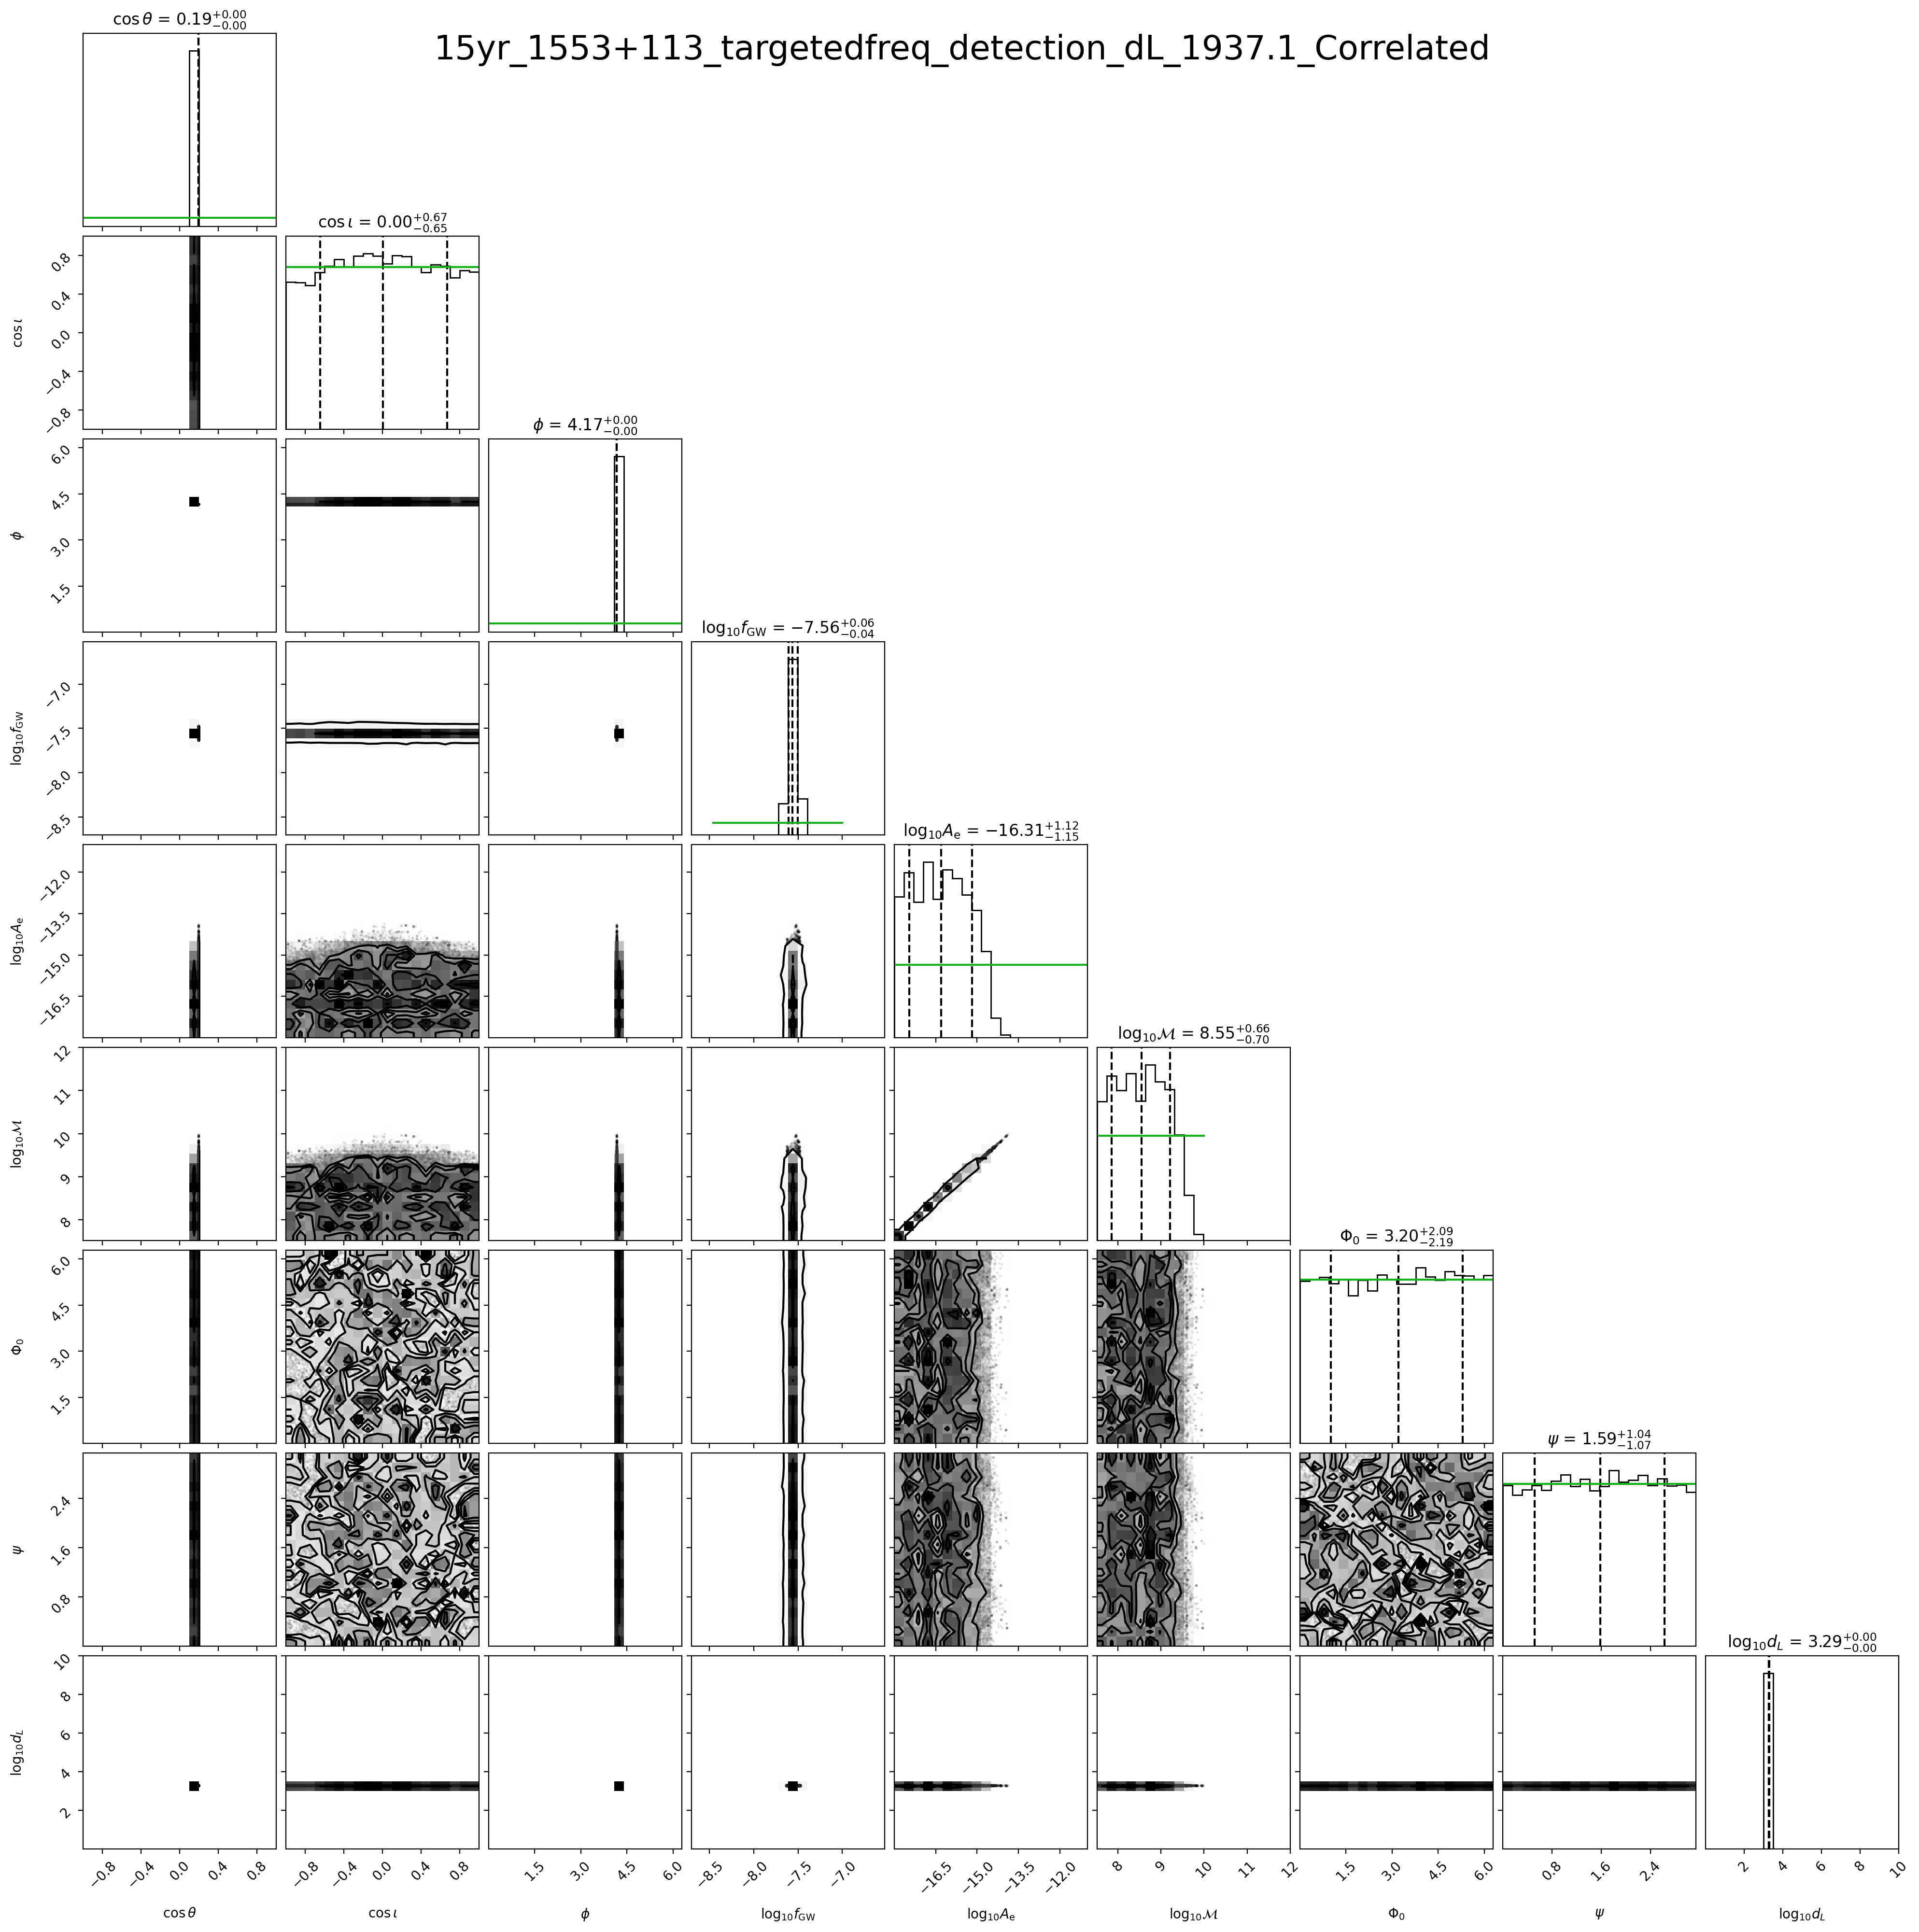

In [36]:
#corner plot of parameters common to all pulsars (Contains Luminosity distance)
corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi","log10_d_L"]
labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
          r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$",r"$\log_{10} d_L$"]

#set burnin and thinning
#burnin = 0
#burnin = 500_000
burnin = int(1e6)
thin = 1

#set ranges
ranges = [(-1,1), (-1,1), (0,2*np.pi), (-8.704,np.log10(3e-7)), (-18,-11), (7.52,12), (0,2*np.pi), (0,np.pi), (0,10)]
#ranges = [0.99]*9


megaparsec = 3.086e+22 #meter
speed_of_light = 299792458.0 #m/s
T_sun = 1.327124400e20 / speed_of_light**3 #G*M_sun/c^3 = R_sun/c-->Sun time

############################################################################
h_amp = 10**samples_cold[0][burnin::thin,4]
fff = 10**samples_cold[0][burnin::thin,3]
mmm = 10**samples_cold[0][burnin::thin,5]

print('hamp',h_amp)
print('freq',fff)
print('mc',mmm)

log10_d_L = np.log10(2 * (mmm*T_sun)**(5/3) * (np.pi*fff)**(2/3) / h_amp *speed_of_light/megaparsec)
print("Length of logdL", len(log10_d_L))
print("required values",np.max(log10_d_L), fff[1000], mmm[1000], h_amp[1000] )
#####################################
#target_d_L = 14254.5 #6667.1 #85.8#93.6#Mpc
d_L_percent_tolerance = 1.0
#####################################

d_L_min = target_d_L*(1-d_L_percent_tolerance/100)
d_L_max = target_d_L*(1+d_L_percent_tolerance/100)
print("dL min",d_L_min)
print("dL max",d_L_max)
print("10**log10_d_L",10**log10_d_L)
print("min 10**log10_d_L",np.min(10**log10_d_L))
print("max 10**log10_d_L",np.max(10**log10_d_L))

d_L_mask = np.where((10**log10_d_L>=d_L_min) & (10**log10_d_L<=d_L_max))[0]
print("d_L_mask",d_L_mask)

#########################
not_d_L_mask_1 = np.where((10**log10_d_L<d_L_min))[0] #& (10**log10_d_L>d_L_max))[0]
print("notd_L_mask1",not_d_L_mask_1)
not_d_L_mask_2 = np.where((10**log10_d_L>d_L_max))[0] #& ())[0]
print("notd_L_mask2",not_d_L_mask_2)

merged_non_dL = np.concatenate((not_d_L_mask_1,not_d_L_mask_2))
print("merged_non_dL",merged_non_dL)
########################################

samples2plot = np.concatenate((samples_cold[0][burnin::thin,corner_mask], np.array([log10_d_L,]).T), axis=1)

print("Sample shape", samples2plot.shape)
print("dL_mask length", len(d_L_mask))
print(len(ranges))
fig = corner.corner(samples2plot[d_L_mask, :],
                    labels=labels,
                    show_titles=True, quantiles=[0.16, 0.5, 0.84],
                    range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0 or i==(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    elif i==2*(len(labels)+1) or i==6*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==3*(len(labels)+1): #log10_fgw
        Xs = np.linspace(np.log10(3.5e-9), -7.0)
        # Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/(np.log10(3e-7)+8.704), color="xkcd:green")
    elif i==4*(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==5*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(np.min(samples2plot[d_L_mask,5]), np.max(samples2plot[d_L_mask,5]))
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==7*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('15yr_1553+113_targetedfreq_detection_dL_1937.1_Correlated', fontsize = 25);

hamp [4.5068535e-15 4.5068535e-15 4.0362585e-15 ... 3.4779832e-16 7.1941796e-16
 1.5630009e-15]
freq [2.9810124e-08 2.9810124e-08 2.9810124e-08 ... 2.4530619e-08 2.4530619e-08
 2.4530619e-08]
mc [8.6710415e+09 8.6710415e+09 8.6710415e+09 ... 2.1166696e+08 2.1166696e+08
 2.1166696e+08]
Length of logdL 9000000
required values 8.09554e+00 2.9810124e-08 8671042000.0 1.740649e-16
dL min 1917.7289999999998
dL max 1956.471
10**log10_d_L [4639.361    4639.361    5180.2725   ...  108.44354    52.426384
   24.130806]
min 10**log10_d_L 0.0031538208
max 10**log10_d_L 124606310.0
d_L_mask [   1587    2220    2221 ... 8999267 8999646 8999947]
notd_L_mask1 [     37      53     112 ... 8999997 8999998 8999999]
notd_L_mask2 [      0       1       2 ... 8999991 8999995 8999996]
merged_non_dL [     37      53     112 ... 8999991 8999995 8999996]
Sample shape (9000000, 9)
dL_mask length 15948
5


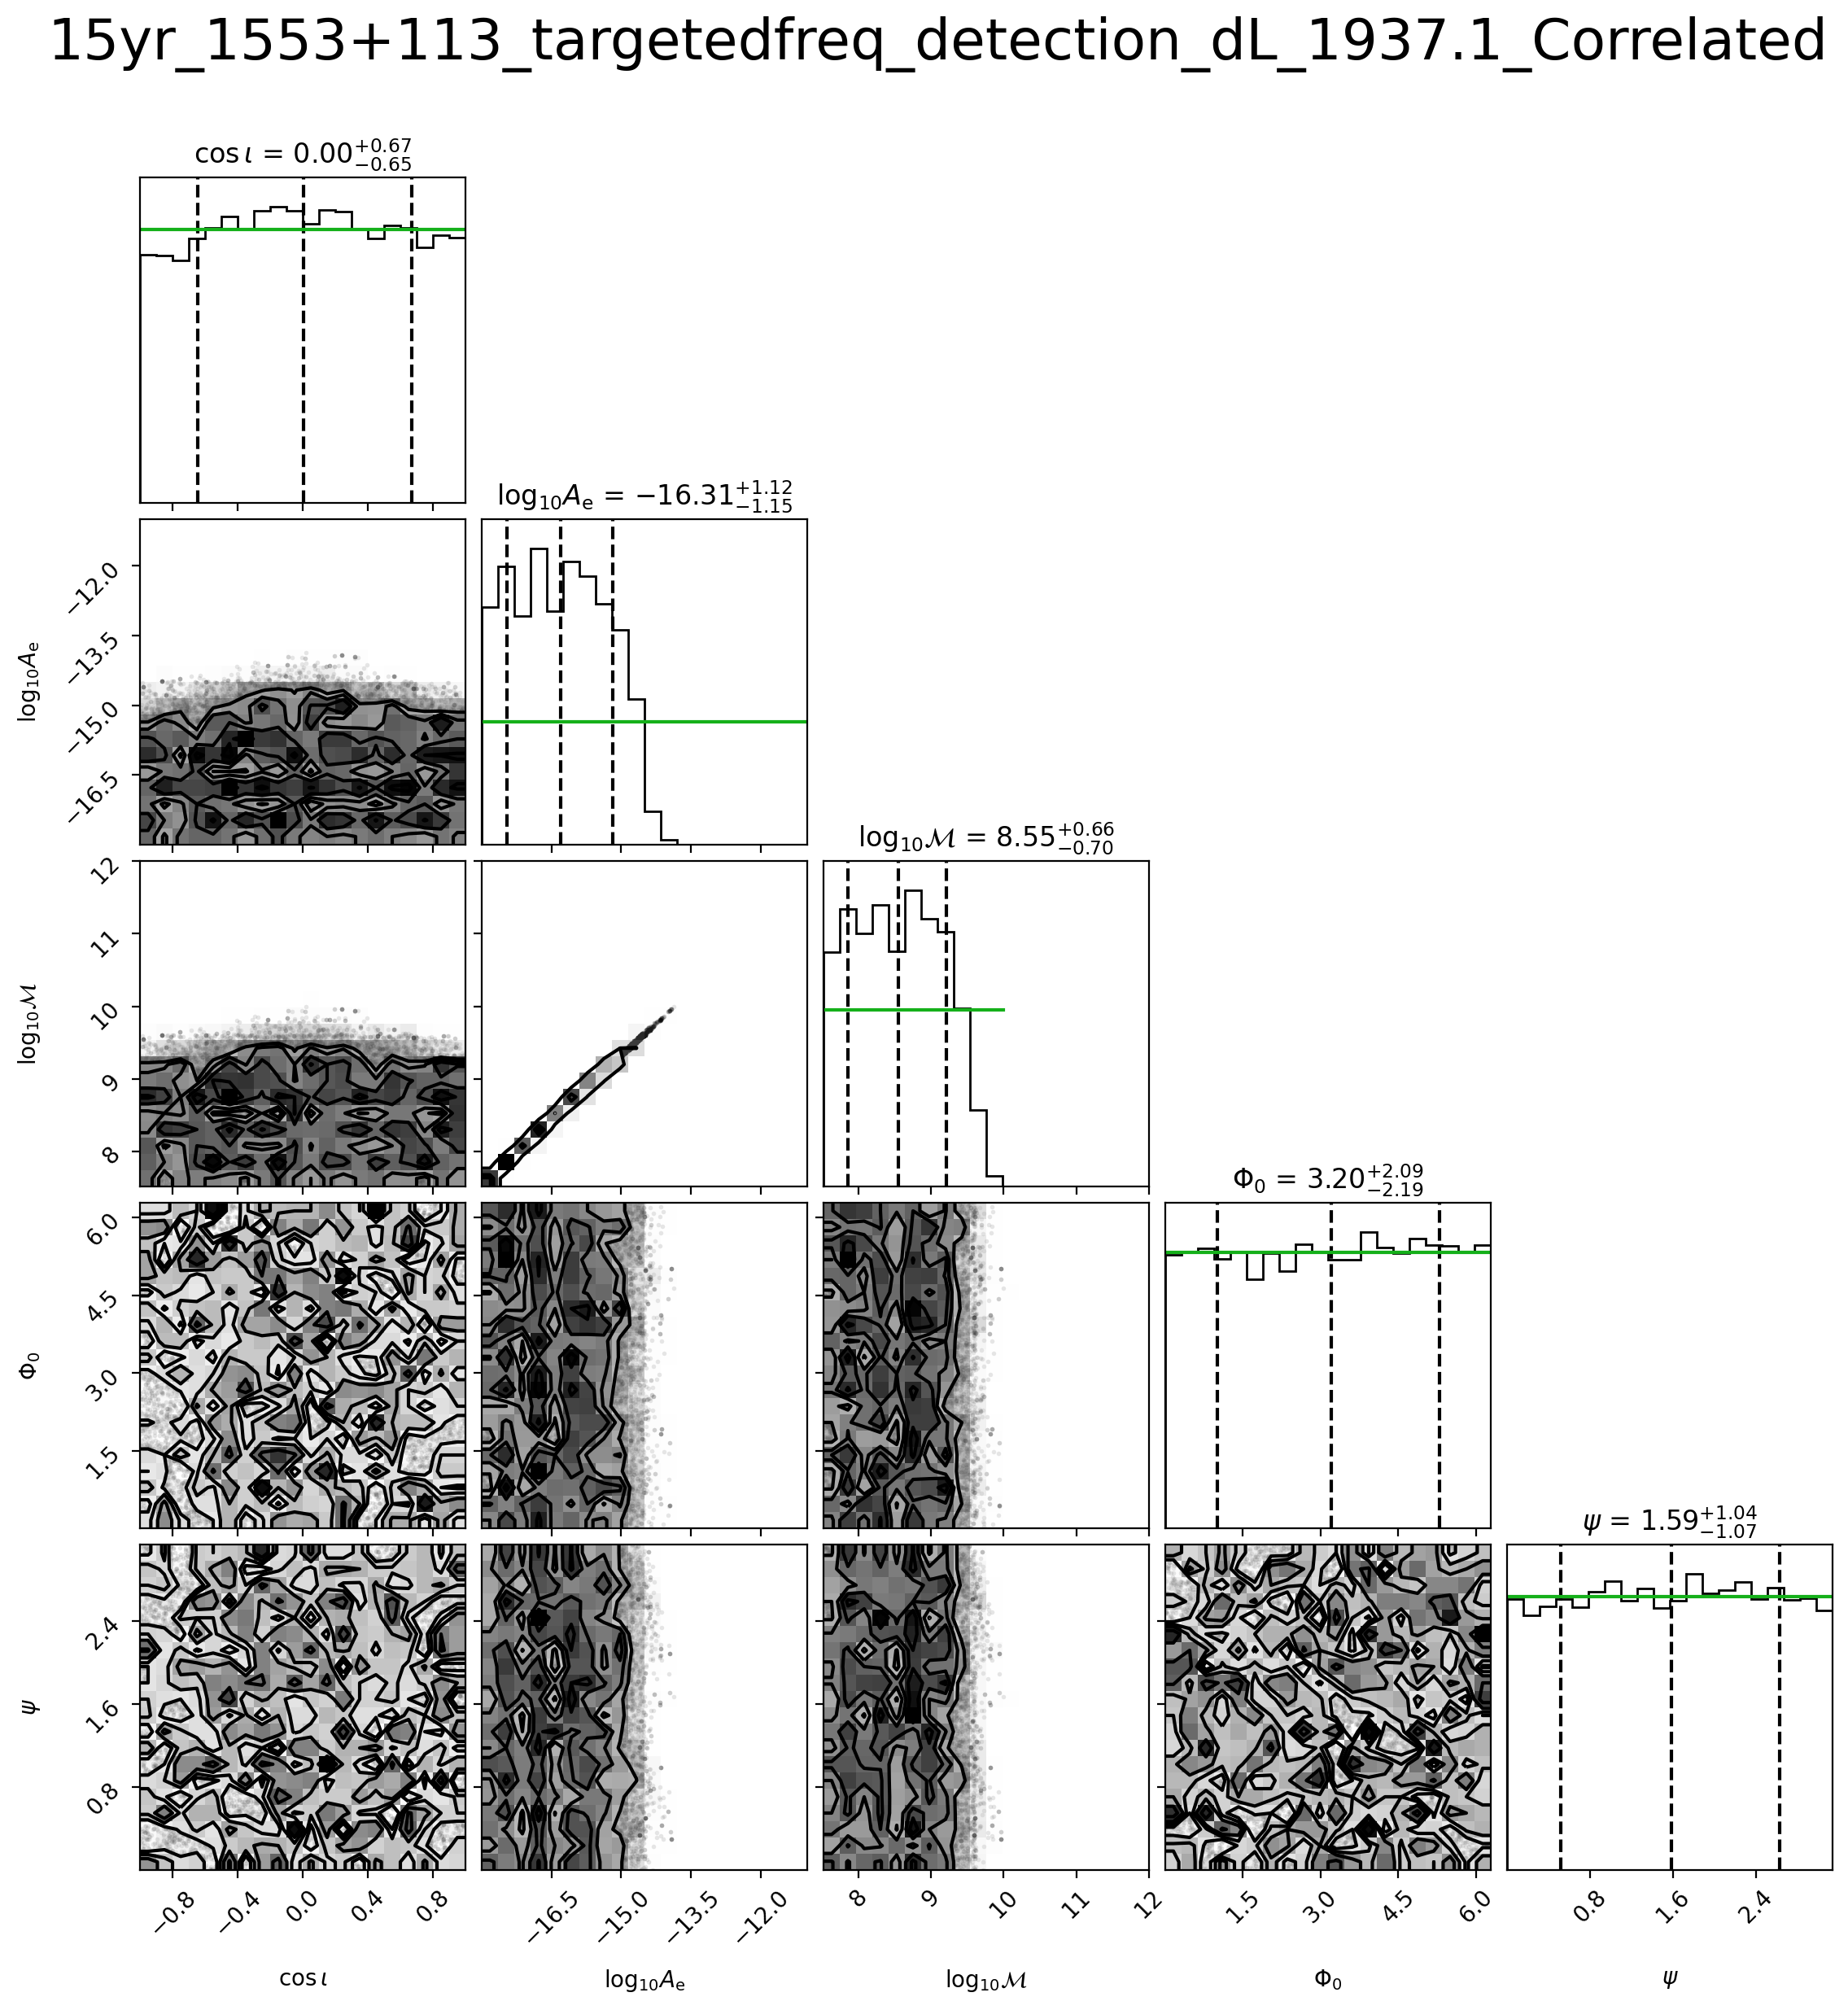

In [37]:
#corner plot of parameters common to all pulsars (Contains Luminosity distance)
corner_mask = [0, 1, 2, 3, 4, 5, 6, 7]
par_keys = ["0_cos_gwtheta", "0_cos_inc", "0_gwphi", "0_log10_fgw",
          "0_log10_h", "0_log10_mc", "0_phase0", "0_psi","log10_d_L"]
#labels = [r"$\cos \theta$", r"$\cos \iota$", r"$\phi$", r"$\log_{10} f_{\rm GW}$",
      #    r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$", r"$\psi$",r"$\log_{10} d_L$"]
labels = [r"$\cos \iota$", r"$\log_{10} A_{\rm e}$", r"$\log_{10} {\cal M}$", r"$\Phi_0$",r"$\psi$"]


#set burnin and thinning
#burnin = 0
#burnin = 500_000
burnin = int(1e6)
thin = 1

#set ranges
ranges = [(-1,1), (-18,-11), (7.52,12), (0,2*np.pi), (0,np.pi)]
#ranges = [(-1,1), (-1,1), (0,2*np.pi), (-8.704,np.log10(3e-7)), (-18,-11), (6.6,12), (0,2*np.pi), (0,np.pi), (0,10)]
#ranges = [0.99]*9


megaparsec = 3.086e+22 #meter
speed_of_light = 299792458.0 #m/s
T_sun = 1.327124400e20 / speed_of_light**3 #G*M_sun/c^3 = R_sun/c-->Sun time

############################################################################
h_amp = 10**samples_cold[0][burnin::thin,4]
fff = 10**samples_cold[0][burnin::thin,3]
mmm = 10**samples_cold[0][burnin::thin,5]

print('hamp',h_amp)
print('freq',fff)
print('mc',mmm)

log10_d_L = np.log10(2 * (mmm*T_sun)**(5/3) * (np.pi*fff)**(2/3) / h_amp *speed_of_light/megaparsec)
print("Length of logdL", len(log10_d_L))
print("required values",np.max(log10_d_L), fff[1000], mmm[1000], h_amp[1000] )
#####################################
#target_d_L = 14254.5 # 6667.1#Mpc
d_L_percent_tolerance = 1.0
#####################################

d_L_min = target_d_L*(1-d_L_percent_tolerance/100)
d_L_max = target_d_L*(1+d_L_percent_tolerance/100)
print("dL min",d_L_min)
print("dL max",d_L_max)
print("10**log10_d_L",10**log10_d_L)
print("min 10**log10_d_L",np.min(10**log10_d_L))
print("max 10**log10_d_L",np.max(10**log10_d_L))

d_L_mask = np.where((10**log10_d_L>=d_L_min) & (10**log10_d_L<=d_L_max))[0]
print("d_L_mask",d_L_mask)

#########################
not_d_L_mask_1 = np.where((10**log10_d_L<d_L_min))[0] #& (10**log10_d_L>d_L_max))[0]
print("notd_L_mask1",not_d_L_mask_1)
not_d_L_mask_2 = np.where((10**log10_d_L>d_L_max))[0] #& ())[0]
print("notd_L_mask2",not_d_L_mask_2)

merged_non_dL = np.concatenate((not_d_L_mask_1,not_d_L_mask_2))
print("merged_non_dL",merged_non_dL)
########################################

samples2plot = np.concatenate((samples_cold[0][burnin::thin,corner_mask], np.array([log10_d_L,]).T), axis=1)

print("Sample shape", samples2plot.shape)
print("dL_mask length", len(d_L_mask))
print(len(ranges))

samples2plot_detect = np.vstack((
                          samples2plot[d_L_mask,1],
                          samples2plot[d_L_mask,4],
                          samples2plot[d_L_mask,5],
                          samples2plot[d_L_mask,6],
                          samples2plot[d_L_mask,7])).T


fig = corner.corner(samples2plot_detect,
                    labels=labels,
                    show_titles=True, quantiles=[0.16, 0.5, 0.84],
                    range=ranges, hist_kwargs={"density":True})

#plot priors over 1D posteriors
for i, ax in enumerate(fig.axes):
    if i==0:#(len(labels)+1): #cos inc and cos theta
        Xs = np.linspace(-1,1)
        ax.plot(Xs, Xs*0+1/2, color="xkcd:green")
    #elif i==3*(len(labels)+1): #log10_fgw
     #   Xs = np.linspace(np.log10(3.5e-9), -7.0)
        # Y = plot_Gaussian(Xs,np.log10(1.13e-8),1)
        # ax.plot(Xs,Y, color='xkcd:green')
      #  ax.plot(Xs, Xs*0+1/(np.log10(3e-7)+8.704), color="xkcd:green")
    elif i==(len(labels)+1): #log10_A
        Xs = np.linspace(-18, -11)
        ax.plot(Xs, Xs*0+1/7, color="xkcd:green")
    elif i==2*(len(labels)+1): #log10_M_ch
        Xs = np.linspace(np.min(samples2plot[d_L_mask,5]), np.max(samples2plot[d_L_mask,5]))
        # Y=plot_Gaussian(Xs,9.86,1)
        # ax.plot(Xs,Y, color='xkcd:green')
        ax.plot(Xs, Xs*0+1/3, color="xkcd:green")
    elif i==3*(len(labels)+1): #gwphi and phase0
        Xs = np.linspace(0,2*np.pi)
        ax.plot(Xs, Xs*0+1/(2*np.pi), color="xkcd:green")
    elif i==4*(len(labels)+1): #psi
        Xs = np.linspace(0,np.pi)
        ax.plot(Xs, Xs*0+1/np.pi, color="xkcd:green")
        
fig.suptitle('15yr_1553+113_targetedfreq_detection_dL_1937.1_Correlated', fontsize = 25,y=1.05);

## Trace Plots

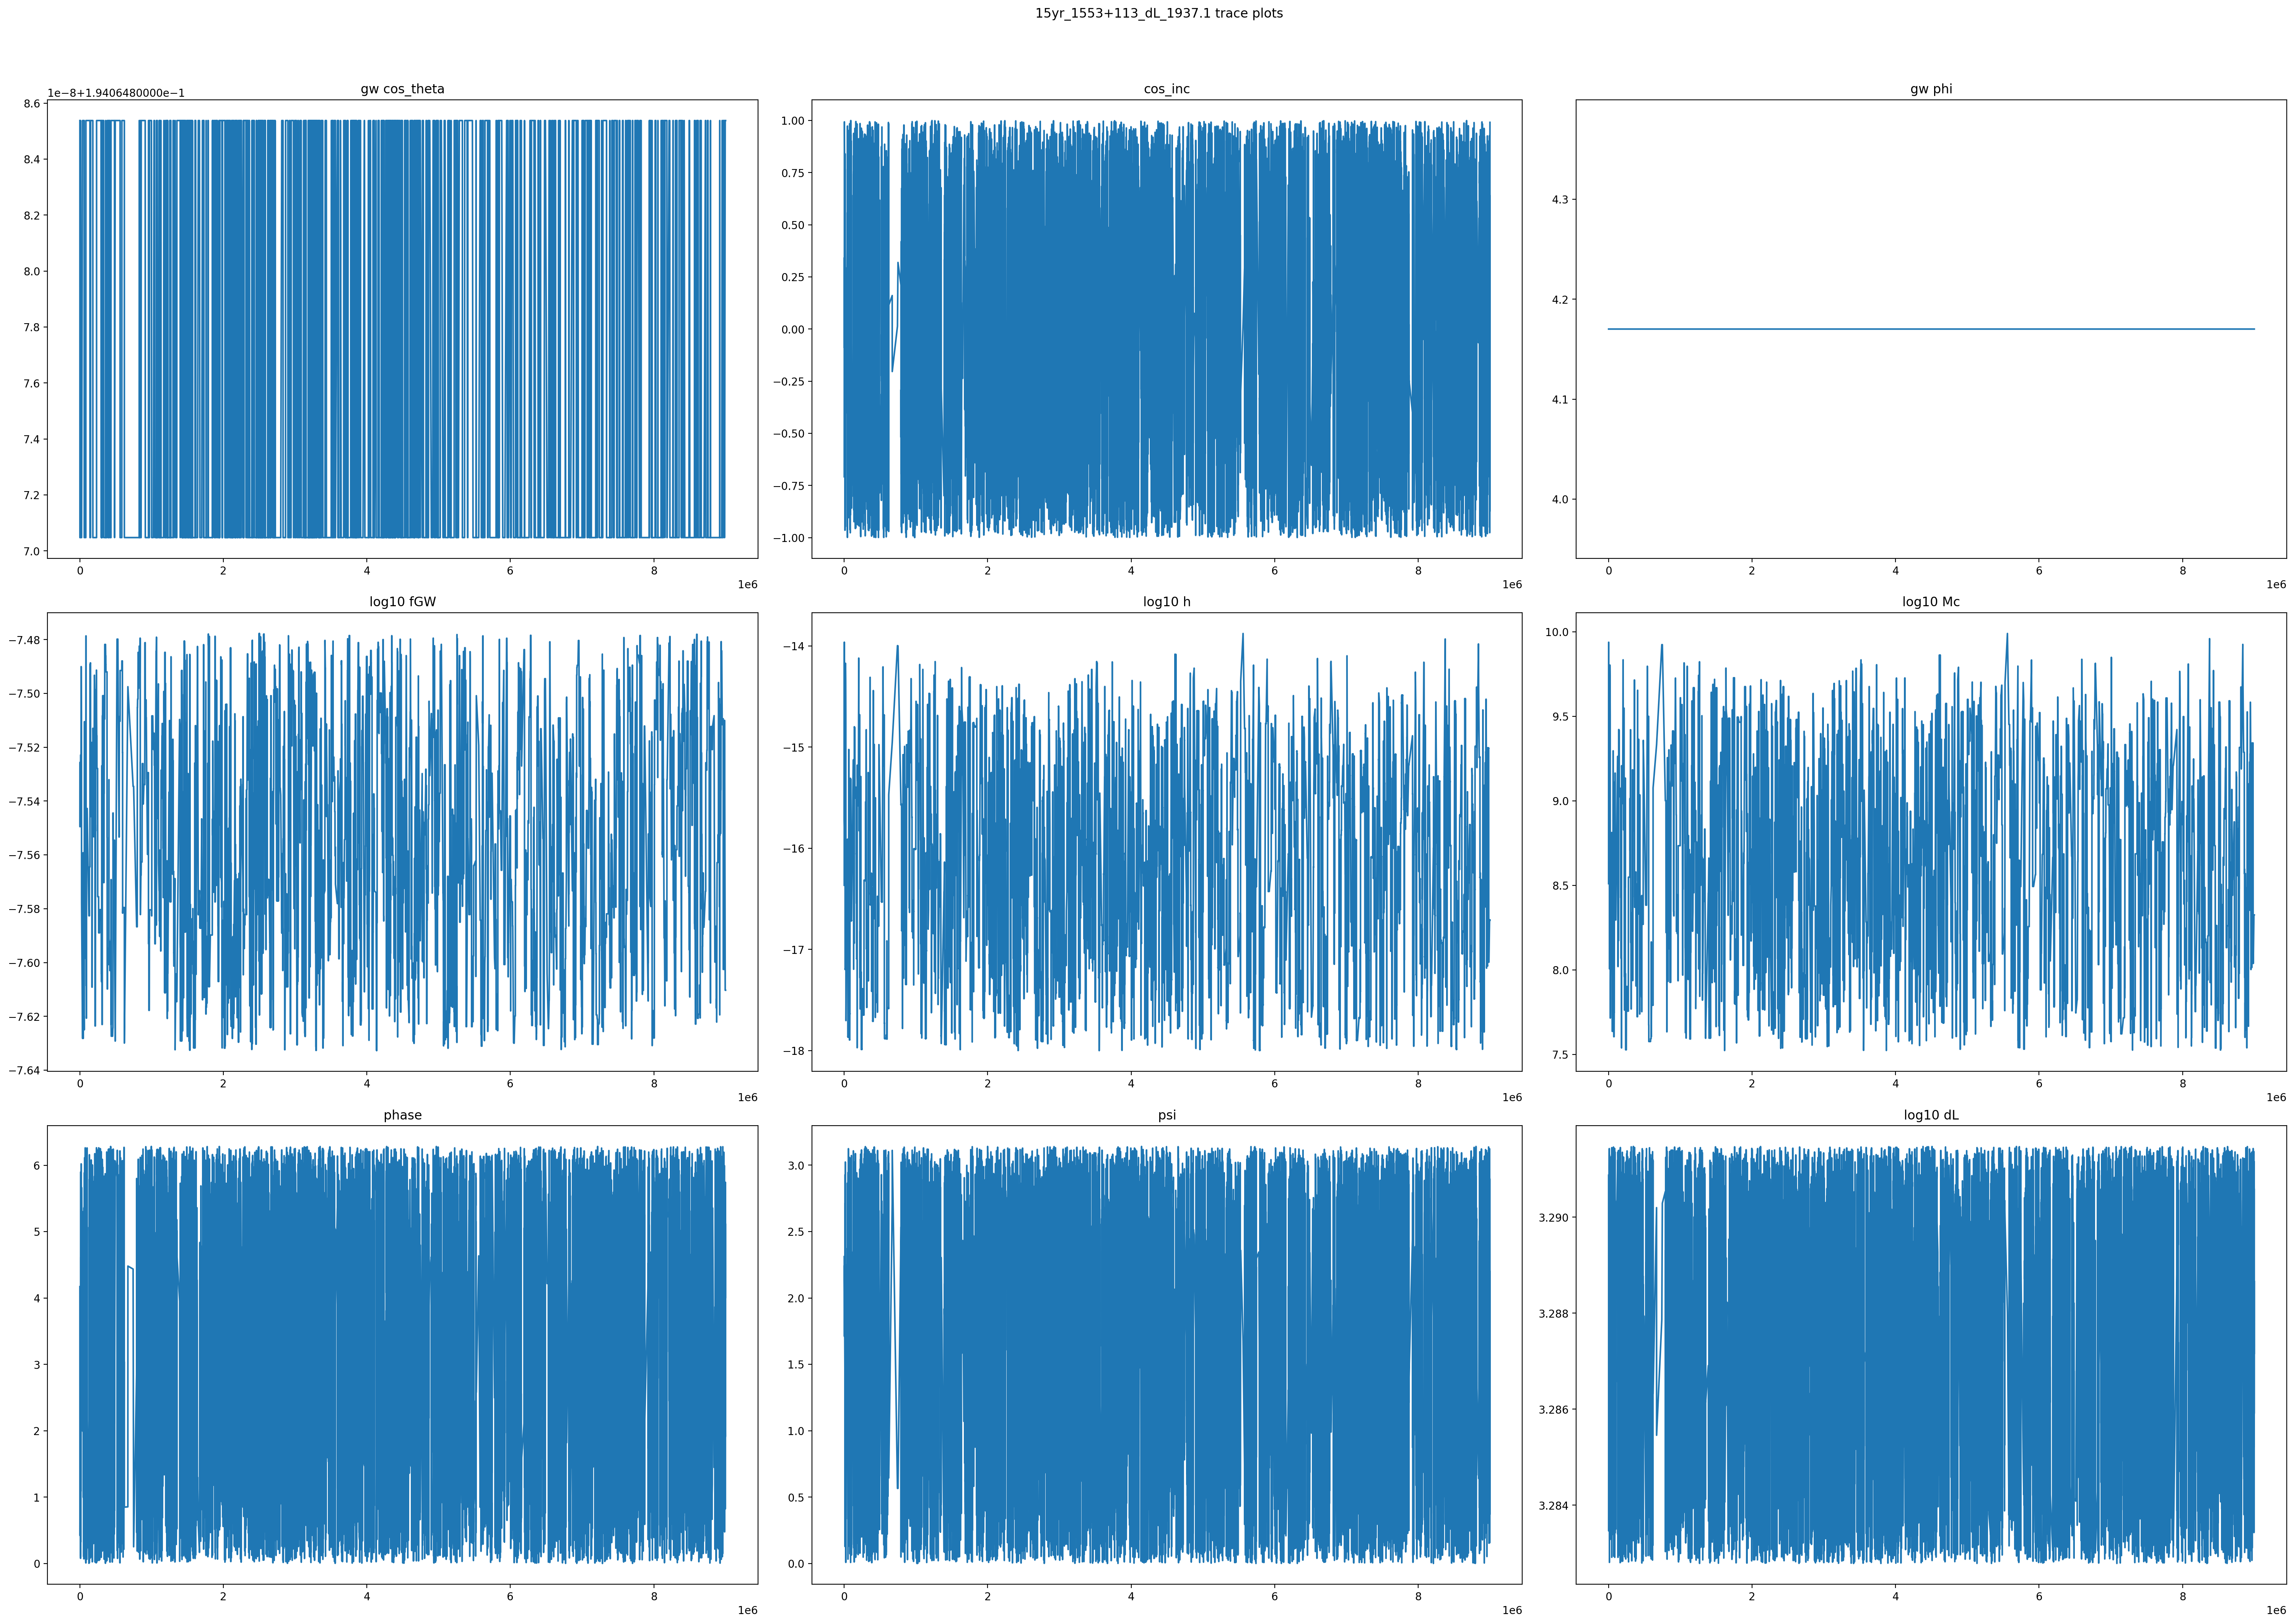

In [38]:
#TRACE PLOTS!!!!!!!

title = ["gw cos_theta", "cos_inc","gw phi","log10 fGW","log10 h","log10 Mc","phase","psi","log10 dL"]

j=-1
row = 3
column = 3
fig, axs = plt.subplots(row, column,figsize=(30,20))#, dpi=80,squeeze=False)
fig.tight_layout(h_pad=3,w_pad=2)
#axs = plt.gca()
for i in range(len(title)): 
    if i%3 == 0:
        j+=1
    #print(j,i)
    axs[j, i%3].plot(d_L_mask, samples2plot[d_L_mask,i])#, ls='', marker='.')
    #axs[j, i%4].ylabel("prior value")
    #axs[j, i%4].xlabel("samples")
    #axs[j, i%4].axhline(xxx[par], ls='--')
    axs[j, i%3].set_title(title[i])
    #axs[0, 0].set_title('Axis [0, 0]')
    #axs[1, i+1].plot(samples_cold[0][::,i+1], ls='', marker='.')

fig.suptitle('15yr_1553+113_dL_1937.1 trace plots', y=1.05)
plt.subplots_adjust()

#display subplots 
#plt.show()
#plt.savefig("/scratch/na00078/QuickCW_targeted_runs/post_processing_scripts/NGC3115/detect/NGC3115_pulsar_trace_plots2.png",dpi='figure',bbox_inches="tight")
#print('done')


## SD BF

hmin -1.7999605e+01
hmax -13.87686
Mc min 7.5236745
Mc max 9.990029
15948


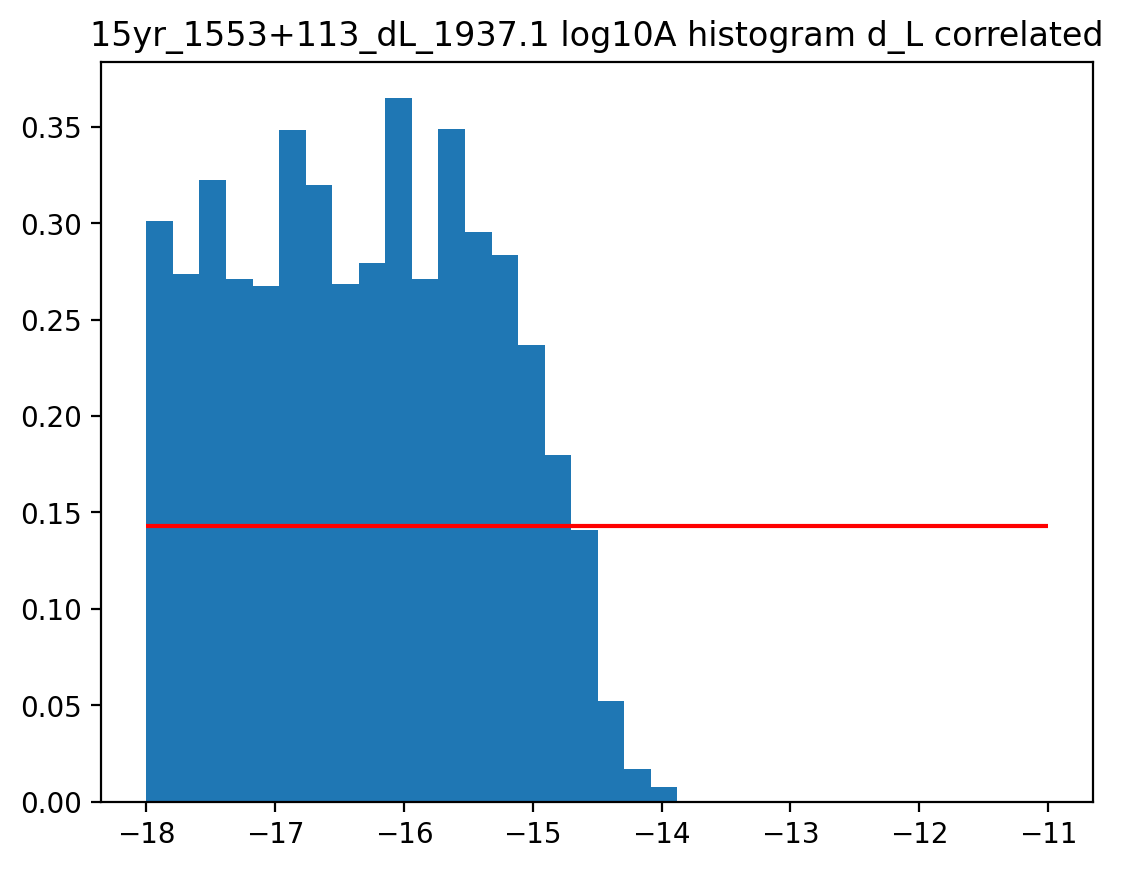

In [39]:
logAmin_dL = np.min(samples2plot[d_L_mask,4])
logAmax_dL = np.max(samples2plot[d_L_mask,4])
print("hmin",logAmin_dL)
print("hmax",logAmax_dL)
print("Mc min",np.min(samples2plot[d_L_mask,5]))
print("Mc max",np.max(samples2plot[d_L_mask,5]))

print(len(samples2plot[d_L_mask,4]))

plt.hist(samples2plot[d_L_mask,4], bins=20, density=True)
plt.hlines(1/(-11 - logAmin_dL), logAmin_dL, -11,  color='red')
plt.title("15yr_1553+113_dL_1937.1 log10A histogram d_L correlated")
plt.show()

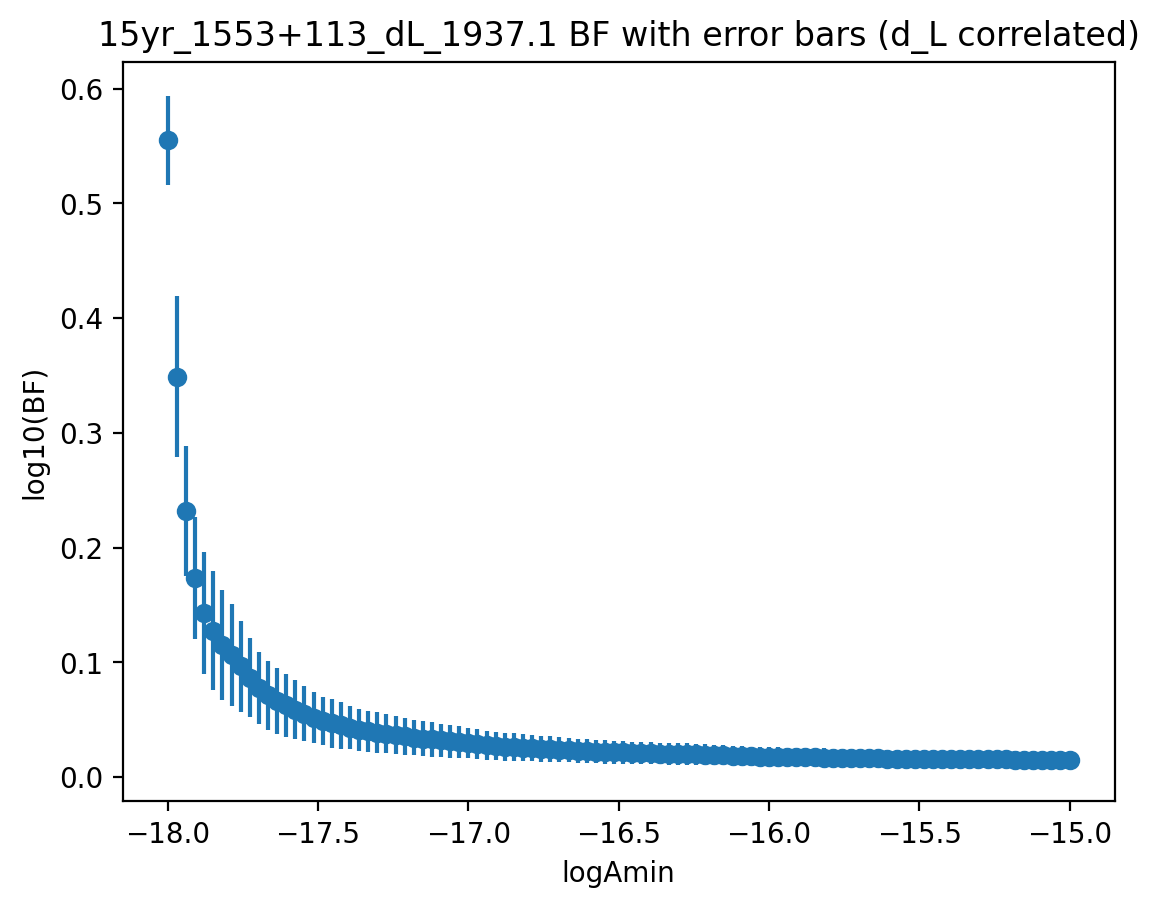

In [40]:
#d_L correlated SD BF
logamins = np.linspace(logAmin_dL, -15, 100)
BF_arr = []
BF_err_arr = []

from enterprise_extensions import model_utils
for logamin in logamins:
    BF,BF_err = model_utils.bayes_fac(samples = samples2plot[d_L_mask,4], logAmin=logamin, logAmax=-11)
    BF_arr.append(BF)
    BF_err_arr.append(BF_err)

plt.errorbar(logamins, BF_arr, yerr=BF_err_arr, fmt='o')
plt.xlabel('logAmin')
plt.ylabel("log10(BF)")
plt.title("15yr_1553+113_dL_1937.1 BF with error bars (d_L correlated)")
plt.show()

In [41]:
print(BF_arr[0:10])

[0.5549575417884907, 0.3489565586150392, 0.23181528477097843, 0.17369922226200696, 0.1428184491304606, 0.12737550327416983, 0.11520586509412106, 0.1062550653212121, 0.09641547552326347, 0.08654373761560023]


In [42]:
print(BF_err_arr[0:10])

[0.03874715166009601, 0.06989675065103755, 0.056561959834746135, 0.05331988459772988, 0.05345642502255852, 0.051742415098270385, 0.04788066069204842, 0.044525118358104195, 0.03959418546836342, 0.03424814321345937]


In [43]:
#Non d_L correlated SD BF
from enterprise_extensions import model_utils
BF,BF_err = model_utils.bayes_fac(samples = samples_cold[0][::10,4], logAmax=-11)
print('log10A BF = ', BF, " +- ", BF_err)

log10A BF =  0.49163457519132747  +-  0.002071611566050616


In [44]:
#d_L correlated SD BF
BF,BF_err = model_utils.bayes_fac(samples = samples2plot[d_L_mask,4], logAmax=-11)
print('log10A BF = ', BF, " +- ", BF_err)

log10A BF =  0.5573197834385268  +-  0.038279147306655825


log10A BF =  0.5573197834385268  +-  0.038279147306655825


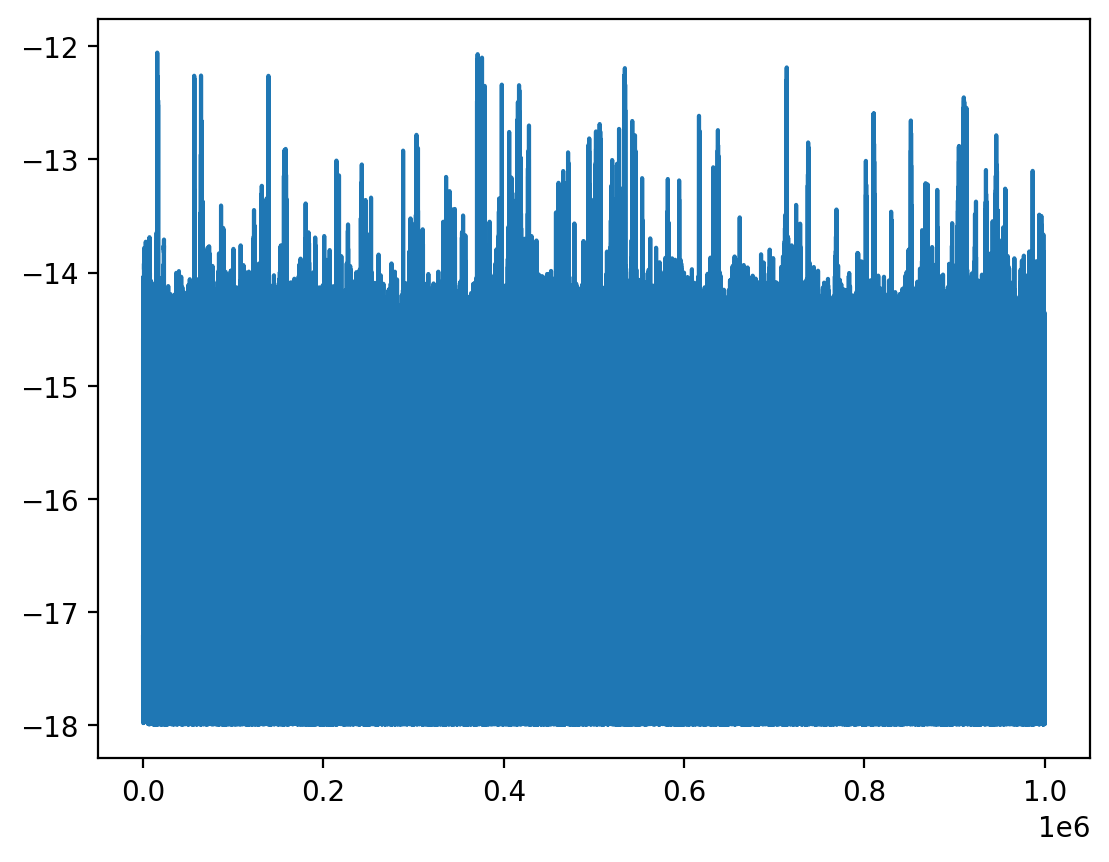

In [45]:
#d_L correlated SD BF
BF,BF_err = model_utils.bayes_fac(samples = samples_cold[0][int(1e6) + d_L_mask,4], logAmax=-11)
print('log10A BF = ', BF, " +- ", BF_err)
plt.plot(samples_cold[0][::10,4])
plt.show()